__Autor: Pablo Veloz M.__
## Desafío - Árboles de Regresión

__Descripción__
- Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos.
- Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable Sale_Price .

__Ejercicio 1: Preparación del ambiente de trabajo__ 
- Importe las librerías clásicas a utilizar.
- Para este ejercicio implementaremos árboles de regresión, por lo que deberá importar la clase DecisionTreeRegressor .
- De manera adicional importe las funciones y clases necesarias para generar un desempeño de métricas en problemas de regresión, división de muestras y búsqueda de grilla con validación cruzada.
- Elimine la columna 'Unnamed: 0' cuando cargue los datos.

In [22]:
import aux_funciones as auxiliares
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  mean_squared_error, median_absolute_error, r2_score

In [23]:
df = pd.read_csv('Archivo para desafío/ames_housing.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head(5)

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


__Ejercicio 2: Feature engineering__
- Identifique si el dtype de cada pd.Serie en nuestra base de datos se considera 'object' o no. Para todas las variables que sean 'object' , realice lo siguiente:
    - 1. Genere una recodificación $K-1$ en cada variable. Para efectos prácticos sólo necesitan eliminar una de las categorías, no se concentren en especificar la categoría a eliminar.Pueden utilizar la función pd.get_dummies con la opción drop_first para ello.
    - 2. Utilizando el método pd.concat , concatene a los atributos creados en la base de datos. tip: No se olvide de eliminar los atributos recodificados, de esta forma evitará un aumento artificial del desempeño del modelo.

__Tipos de datos en el Dataframe__

In [24]:
df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

__Almacenando columnas dtype('O')__

In [25]:
listado_object=[]
for i in df.columns:
    if df[i].dtype=='O':
        listado_object.append(i)
print(len(listado_object))

46


__Creando un nuevo dataframe df_dummies, considerando df y las columnas dtype('O') en dummy__

In [26]:
df_dummies = pd.get_dummies(df, drop_first=True, columns=listado_object)
df_dummies.head()


,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0
2,81,14267,1958,1958,108,1,0,406,1329,1329,...,0,0,0,0,1,0,0,0,1,0
3,93,11160,1968,1968,0,1,0,1045,2110,2110,...,0,0,0,0,1,0,0,0,1,0
4,74,13830,1997,1998,0,3,0,137,928,928,...,0,0,0,0,1,0,0,0,1,0


__Ejercicio 3: Primer modelo__
- Genere muestras de entrenamiento y validación con 'Sale_Price' como vector objetivo y los atributos de la base de datos como matriz. Recuerde definir el porcentaje de casos en la muestra de validación y una semilla pseudoaleatoria.
- Posteriormente, entrene un árbol de regresión en la muestra de entrenamiento sin modificar los hiperparámetros. Reporte las principales métricas de desempeño. Comente sobre el desempeño.

Antes, __inspeccionando variable objetivo__

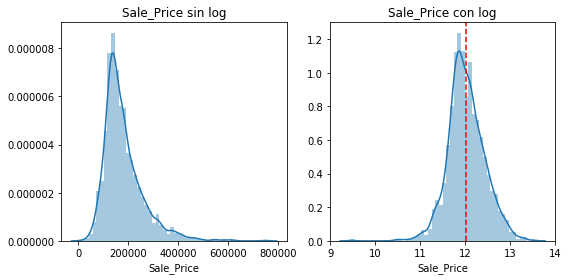

In [27]:
plt.figure(figsize=(8,4))
lista=[1,2]
for n,i in enumerate(lista):
    plt.subplot(1, 2, n + 1)
    if i==1:  
        sns.distplot(df_dummies['Sale_Price'])
        plt.title('Sale_Price sin log')
        plt.tight_layout()
    else:
        dist=sns.distplot(np.log(df_dummies['Sale_Price']))
        dist.axvline(np.log(df_dummies['Sale_Price']).mean(), color='r', linestyle='--')
        plt.title('Sale_Price con log')
        plt.tight_layout()
#sns.lineplot(, palette="tab10", linewidth=2.5)

__Con los datos agrupados y más cercanos al promedio de 12, se realiza el test split de la variable objetivo aplicando log__

__Test split__

In [28]:
y_vec=np.log(df_dummies['Sale_Price'])
X_mat=df_dummies.drop('Sale_Price',axis=1)
X_train,X_test,y_train,y_test=train_test_split(X_mat,y_vec,test_size=0.33,random_state=1)

__Modelo Decision Tree__

In [29]:
dec_tree = DecisionTreeRegressor(random_state = 1).fit(X_train, y_train)


__Predict__

In [30]:
y_hat = dec_tree.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_hat).round(5))
print("MAE:", median_absolute_error(y_test, y_hat).round(5))
print("R2:", r2_score(y_test, y_hat).round(5))

MSE: 0.04658
MAE: 0.09531
R2: 0.72543


__Ejercicio 4: Importancia relativa__
- Implemente el método plot_importance utilizado en la lectura para reportar la importancia relativa de los atributos.
- Comente sobre cuáles son los principales 10 atributos que afectan la predicción de `Sale_Price`.
- Separe éstos 10 atributos en una nueva base de datos, junto con el vector objetivo.

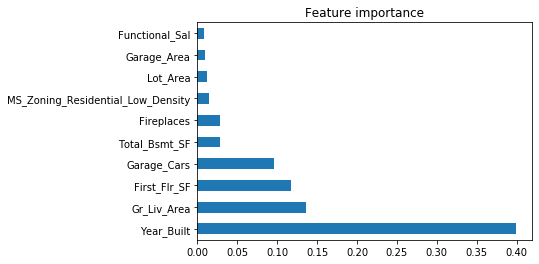

In [31]:
important_features=auxiliares.plot_importance(dec_tree,X_mat.columns)

In [32]:
df_important = df_dummies[list(important_features) + ['Sale_Price']]
df_important.head()

,Year_Built,Gr_Liv_Area,First_Flr_SF,Garage_Cars,Total_Bsmt_SF,Fireplaces,MS_Zoning_Residential_Low_Density,Lot_Area,Garage_Area,Functional_Sal,Sale_Price
0,1960,1656,1656,2,1080,2,1,31770,528,0,215000
1,1961,896,896,1,882,0,0,11622,730,0,105000
2,1958,1329,1329,1,1329,0,1,14267,312,0,172000
3,1968,2110,2110,2,2110,2,1,11160,522,0,244000
4,1997,1629,928,2,928,1,1,13830,482,0,189900


__Ejercicio 5: Refactorización del modelo y pickling__
- En función de los atributos seleccionados en el ejercicio anterior, vuelva a generar conjuntos de entrenamiento y validación.
- Dentro de los datos de entrenamiento genere una búsqueda de grila con GridSearchCV utilizando los siguientes hiperparámetros:
- Máximo de atributos: Evalúe todos los posibles atributos.
- Máximo de profundidad: entre 1 a 32.
- Validaciones cruzadas : 5.
- Reporte la mejor combinación de hiperparámetros y su desempeño asociado. Compare el desempeño en la muestra de validación con el modelo por defecto.Pickling
- Ahora generaremos una serialización de nuestro modelo depurado, y nuestros conjuntos de entrenamiento y validación depurados. Para ello importe el módulo pickle . pickle contiene la función dump , que permite guardar el modelo desarrollado. La forma canónica para desarrollar el pickling es:
        -pickle.dump(<OBJETO_CON_EL_MODELO>, open('nombre-apellido-actividad07.sav','wb'))
- Envíe su modelo y conjuntos de entrenamiento a un compañero.

__Modelo 2: Depurado__

In [33]:
y_vec=np.log(df_important['Sale_Price'])
X_mat=df_important.drop('Sale_Price',axis=1)
X_train,X_test,y_train,y_test=train_test_split(X_mat,y_vec,test_size=0.33,random_state=1)

In [34]:
params = {
    'max_depth': np.linspace(1, 32, 32),
    'max_features': list(range(1, X_train.shape[1]+1))
}

cv = GridSearchCV(DecisionTreeRegressor(random_state = 1), params, cv=5)

In [35]:
result = cv.fit(X_train, y_train)

In [36]:
result.best_params_
best_max_depth = result.best_params_['max_depth']
best_max_features = result.best_params_['max_features']

print('best max depth: ',best_max_depth,'\n'+'best max features: '+str(best_max_features))

best max depth:  6.0 
best max features: 7


In [45]:
y_hat = result.best_estimator_.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_hat).round(5))
print("MAE:", median_absolute_error(y_test, y_hat).round(5))
print("R2:", r2_score(y_test, y_hat).round(5))

MSE: 0.04746
MAE: 0.09893
R2: 0.72029


In [46]:
y_test.shape

(967,)

In [47]:
y_hat.shape

(967,)

In [38]:
import pickle

In [39]:
pickle.dump(result.best_estimator_, open('pablo-veloz-actividad07.sav','wb'))

In [49]:
X_train.to_csv('X_train',index=False)
X_test.to_csv('X_test',index=False)
y_test.to_csv('y_test',index=False)

### Analisis de los Modelos


In [41]:
metricas=['MSE','MAE','R2'] 
modelo1=[0.04658,0.09531,0.72543]
modelo2=[0.04746,0.09893,0.72029]
modelo3=[0,0,0]
listado = list(zip(metricas,modelo1,modelo2,modelo3))
pd.DataFrame(listado, columns = ['metricas','Modelo 1', 'Modelo Depurado','Modelo Tania'])

,metricas,Modelo 1,Modelo Depurado,Modelo Tania
0,MSE,0.04658,0.04746,0
1,MAE,0.09531,0.09893,0
2,R2,0.72543,0.72029,0
